In [1]:
# Input info
# se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/clonal_shifts/clones/"
# N_DONORS = 2
# condition = "inputOnly" # noInput

#config
input_cond = "Input"
clone_col = "name"
atac_col = "cluster_labels"

# params
min_clone_size = 2
p_thresh = 0.1 

n_cpus = 8

n_shuffle=1000
#conds_sep = False


se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_None/clones/variants_simpleUnion/knn/kparam_30/cells_meta.tsv" 
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_None/clonal_shifts/variants_simpleUnion/clones/results/noInput/knn/kparam_30/" 

N_DONORS = 5 
condition = "noInput" #inputOnly



In [2]:
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

### Setup outdirs

In [3]:
all_dir = join(outdir,"combDonors")
sep_dir = join(outdir,"sepDonors")


if not exists(all_dir):
    os.mkdir(all_dir)
    
if not exists(sep_dir):
    os.mkdir(sep_dir)

donor_out = {}
for d in np.arange(N_DONORS):
    donor_out[d] = join(sep_dir, f"donor{d}")
    if not exists(donor_out[d]):
        os.mkdir(donor_out[d])
        
    
# sim_all_dir = join(all_dir, "shuffle")
# sim_sep_dir = join(sep_dir, "shuffle")
# if not exists(sep_dir):
#     os.mkdir(sep_dir)
# if not exists(sim_all_dir):
#     os.mkdir(sim_all_dir)


In [4]:
%load_ext autoreload
%autoreload 2

## Load barcodes, and add donor id for the labels

## Load cells_meta

In [5]:
cells_meta = pd.read_csv(se_cells_meta_f, sep="\t", index_col=0)
if cells_meta.index.duplicated().any():
    cells_meta = cells_meta.reset_index()
    
cells_meta = cells_meta.loc[~(cells_meta["name"]=="None")]

if not "cluster_labels" in cells_meta.columns.values:
    cells_meta["cluster_labels"] = cells_meta["seurat_clusters"]
cells_meta

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,seurat_clusters,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels
Input_AAACGAATCCCAGTAA-1,Input,2103,2103,30056.0,2764,124,63,832,22385,3888,...,2,2540,2215,AAACGAATCCCAGTAA-1_Input,Input_AAACGAATCCCAGTAA-1,0,0,Input,0_0,2
Input_AAACGAATCGTGAACT-1,Input,5996,5996,66340.0,10716,362,165,2305,39978,12814,...,4,8689,5714,AAACGAATCGTGAACT-1_Input,Input_AAACGAATCGTGAACT-1,19,0,Input,0_19,4
Input_AAACTGCAGGATGTAT-1,Input,3421,3421,34970.0,5801,165,87,972,22347,5598,...,1,3701,2984,AAACTGCAGGATGTAT-1_Input,Input_AAACTGCAGGATGTAT-1,34,0,Input,0_34,1
Input_AAACTGCAGTCTCTAG-1,Input,3129,3129,31794.0,6835,210,90,1208,13249,10202,...,2,5219,3174,AAACTGCAGTCTCTAG-1_Input,Input_AAACTGCAGTCTCTAG-1,20,0,Input,0_20,2
Input_AAAGATGCATGGGACA-1,Input,3690,3690,41653.0,6545,239,82,1252,26909,6626,...,11,4092,3217,AAAGATGCATGGGACA-1_Input,Input_AAAGATGCATGGGACA-1,30,0,Input,0_30,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Flt3l_TAAGTGCAGACCATAA-1,Flt3l,7205,7205,191871.0,39665,787,631,3689,136368,10731,...,9,9781,5927,TAAGTGCAGACCATAA-1_Flt3l,Flt3l_TAAGTGCAGACCATAA-1,7,4,Flt3l,4_7,9
Flt3l_TGCTATTCAGTAACCT-1,Flt3l,5875,5875,226983.0,36784,912,853,4192,175633,8609,...,9,7634,4926,TGCTATTCAGTAACCT-1_Flt3l,Flt3l_TGCTATTCAGTAACCT-1,7,4,Flt3l,4_7,9
Flt3l_TGGAAGGTCGCGTTCT-1,Flt3l,4022,4022,205848.0,22609,510,608,2547,173892,5682,...,9,5196,3706,TGGAAGGTCGCGTTCT-1_Flt3l,Flt3l_TGGAAGGTCGCGTTCT-1,7,4,Flt3l,4_7,9
Flt3l_TTAACGGGTGCGTTTA-1,Flt3l,10535,10535,163216.0,39800,932,663,4013,101714,16094,...,9,13364,7464,TTAACGGGTGCGTTTA-1_Flt3l,Flt3l_TTAACGGGTGCGTTTA-1,7,4,Flt3l,4_7,9


## Map the new group to cells_meta

## Filter for condition

In [6]:
if condition == "inputOnly":
    cells_meta = cells_meta.loc[cells_meta["condition"]==input_cond]
else:
    cells_meta = cells_meta.loc[cells_meta["condition"]!=input_cond]
#sns.countplot(data=cells_meta,x=clone_col)
cells_meta

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,seurat_clusters,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels
Flt3l_AAAGATGCAGCAACGA-1,Flt3l,10455,10455,250347.0,85267,1663,1230,6598,134365,21224,...,2,17199,8217,AAAGATGCAGCAACGA-1_Flt3l,Flt3l_AAAGATGCAGCAACGA-1,4,1,Flt3l,1_4,2
Flt3l_AACAAAGAGCGATACG-1,Flt3l,6673,6673,170130.0,63476,1338,877,8200,75212,21027,...,2,12244,7057,AACAAAGAGCGATACG-1_Flt3l,Flt3l_AACAAAGAGCGATACG-1,48,1,Flt3l,1_48,2
Flt3l_AACCGATAGGCACCTC-1,Flt3l,8663,8663,162791.0,54220,1154,832,7020,83882,15683,...,13,13358,7292,AACCGATAGGCACCTC-1_Flt3l,Flt3l_AACCGATAGGCACCTC-1,2,1,Flt3l,1_2,13
Flt3l_ACAAACCGTAGAGAGA-1,Flt3l,11648,11648,227834.0,59906,977,928,7091,138752,20180,...,9,15743,8248,ACAAACCGTAGAGAGA-1_Flt3l,Flt3l_ACAAACCGTAGAGAGA-1,34,1,Flt3l,1_34,9
Flt3l_ACATGCAAGACCCTAT-1,Flt3l,10141,10141,199560.0,58831,1105,806,6973,113844,18001,...,9,14263,7991,ACATGCAAGACCCTAT-1_Flt3l,Flt3l_ACATGCAAGACCCTAT-1,2,1,Flt3l,1_2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Flt3l_TAAGTGCAGACCATAA-1,Flt3l,7205,7205,191871.0,39665,787,631,3689,136368,10731,...,9,9781,5927,TAAGTGCAGACCATAA-1_Flt3l,Flt3l_TAAGTGCAGACCATAA-1,7,4,Flt3l,4_7,9
Flt3l_TGCTATTCAGTAACCT-1,Flt3l,5875,5875,226983.0,36784,912,853,4192,175633,8609,...,9,7634,4926,TGCTATTCAGTAACCT-1_Flt3l,Flt3l_TGCTATTCAGTAACCT-1,7,4,Flt3l,4_7,9
Flt3l_TGGAAGGTCGCGTTCT-1,Flt3l,4022,4022,205848.0,22609,510,608,2547,173892,5682,...,9,5196,3706,TGGAAGGTCGCGTTCT-1_Flt3l,Flt3l_TGGAAGGTCGCGTTCT-1,7,4,Flt3l,4_7,9
Flt3l_TTAACGGGTGCGTTTA-1,Flt3l,10535,10535,163216.0,39800,932,663,4013,101714,16094,...,9,13364,7464,TTAACGGGTGCGTTTA-1_Flt3l,Flt3l_TTAACGGGTGCGTTTA-1,7,4,Flt3l,4_7,9


## construct the clone_groups and atac_cl_groups

## A) Loop through donor and run 

donor 1
['1_0' '1_10' '1_11' '1_12' '1_18' '1_19' '1_2' '1_20' '1_21' '1_25'
 '1_27' '1_28' '1_30' '1_33' '1_34' '1_36' '1_4' '1_42' '1_47' '1_48'
 '1_5' '1_50' '1_51' '1_52' '1_53' '1_8' '1_9']
[ 2  3  9 12 13 14]
Running hypergeo and saving sig results
plotting counts


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 7
bh shape (27, 6)


ic| 'clone min'


out_df     index variable  value      method
32   1_19        3    0.0  global_all
51   1_53        3    0.0  global_all
55   1_10        9    0.0  global_all
56   1_11        9    0.0  global_all
57   1_12        9    0.0  global_all
..    ...      ...    ...         ...
75   1_50        9    0.0   clone_min
76   1_51        9    0.0   clone_min
96   1_36       12    0.0   clone_min
134   1_9       13    0.0   clone_min
152  1_42       14    0.0   clone_min

[80 rows x 4 columns]
donor 2
['2_0' '2_1' '2_10' '2_12' '2_13' '2_16' '2_17' '2_18' '2_2' '2_20' '2_3'
 '2_35' '2_37' '2_38' '2_4' '2_47' '2_5' '2_55' '2_8']
[ 0  2  4  9 10 12 13 14]
Running hypergeo and saving sig results
plotting counts


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 5
bh shape (19, 8)


ic| 'clone min'


out_df     index variable  value      method
2    2_10        0    0.0  global_all
61   2_13        9    0.0  global_all
62   2_16        9    0.0  global_all
63   2_17        9    0.0  global_all
67    2_3        9    0.0  global_all
68   2_35        9    0.0  global_all
69   2_37        9    0.0  global_all
70   2_38        9    0.0  global_all
72   2_47        9    0.0  global_all
74   2_55        9    0.0  global_all
75    2_8        9    0.0  global_all
79   2_12       10    0.0  global_all
96    2_1       12    0.0  global_all
142  2_20       14    0.0  global_all
2    2_10        0    0.0  global_min
61   2_13        9    0.0  global_min
62   2_16        9    0.0  global_min
63   2_17        9    0.0  global_min
67    2_3        9    0.0  global_min
68   2_35        9    0.0  global_min
69   2_37        9    0.0  global_min
70   2_38        9    0.0  global_min
72   2_47        9    0.0  global_min
74   2_55        9    0.0  global_min
75    2_8        9    0.0  global_min
79   

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:805: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)
ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 2
bh shape (6, 3)


ic| 'clone min'


out_df    index variable  value      method
6   3_14        9    0.0  global_all
8   3_28        9    0.0  global_all
10  3_41        9    0.0  global_all
15  3_33       10    0.0  global_all
6   3_14        9    0.0  global_min
8   3_28        9    0.0  global_min
10  3_41        9    0.0  global_min
15  3_33       10    0.0  global_min
6   3_14        9    0.0   clone_all
8   3_28        9    0.0   clone_all
10  3_41        9    0.0   clone_all
15  3_33       10    0.0   clone_all
6   3_14        9    0.0   clone_min
8   3_28        9    0.0   clone_min
10  3_41        9    0.0   clone_min
15  3_33       10    0.0   clone_min
donor 4
['4_6' '4_7']
[4 9]
Running hypergeo and saving sig results
plotting counts


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'
ic| 'clone all'


Number of groups below p-val significance: 0
axs 1
bh shape (2, 2)


ic| 'clone min'


out_df   index variable  value      method
1   4_7        4    0.0  global_all
2   4_6        9    0.0  global_all
1   4_7        4    0.0  global_min
2   4_6        9    0.0  global_min
1   4_7        4    0.0   clone_all
2   4_6        9    0.0   clone_all
1   4_7        4    0.0   clone_min
2   4_6        9    0.0   clone_min


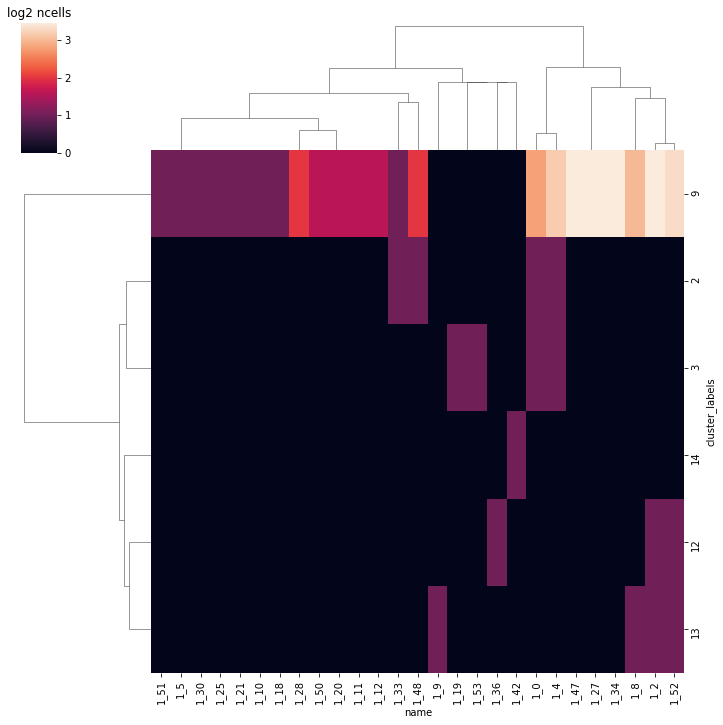

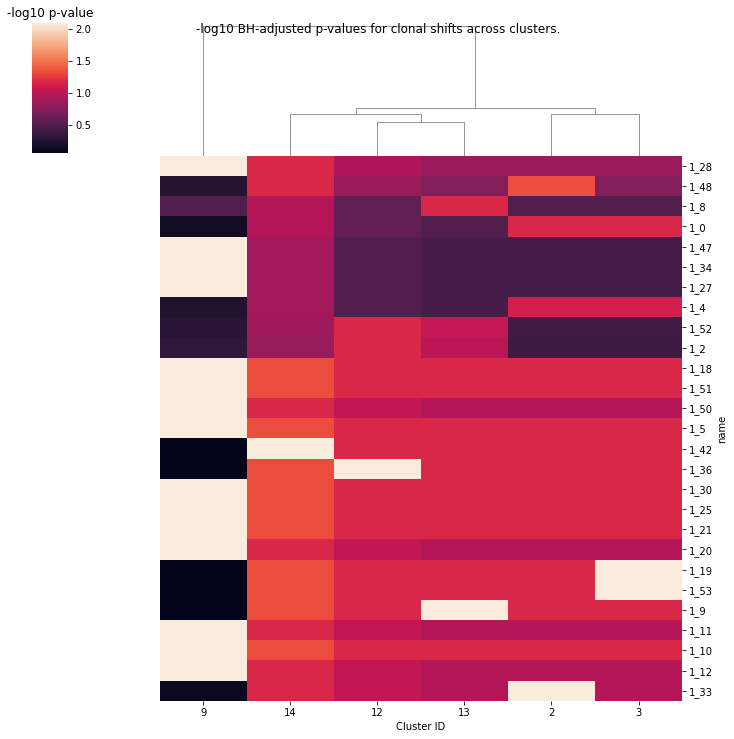

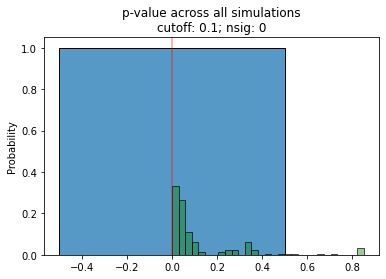

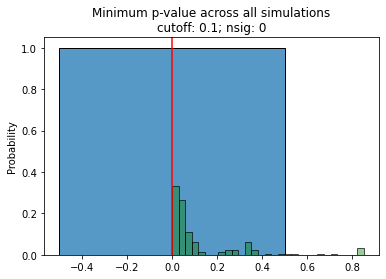

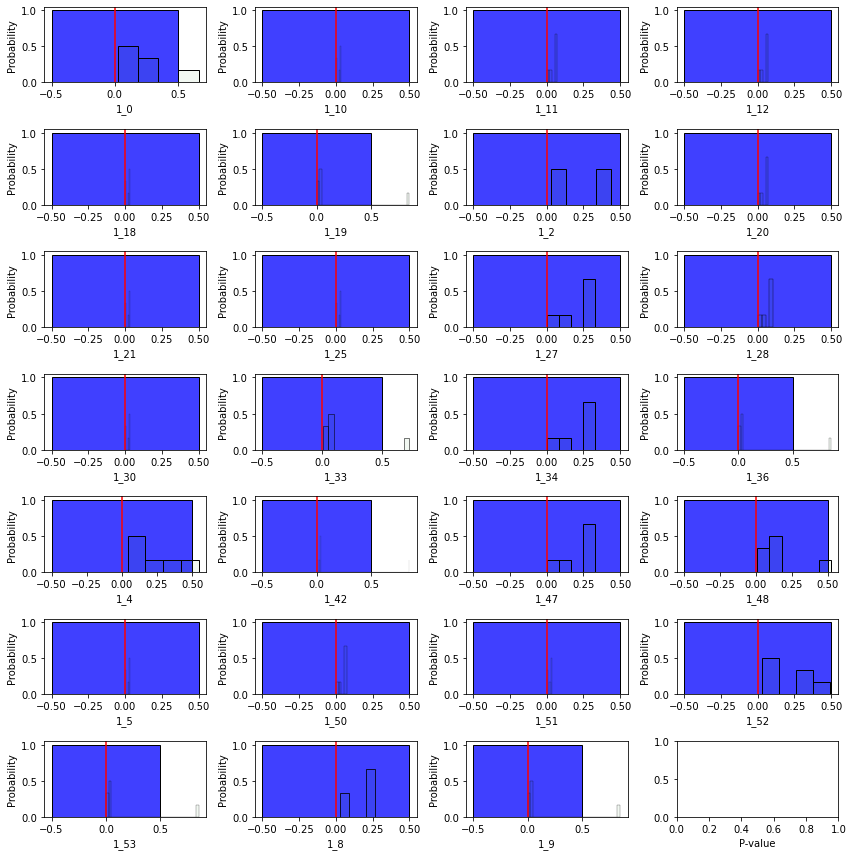

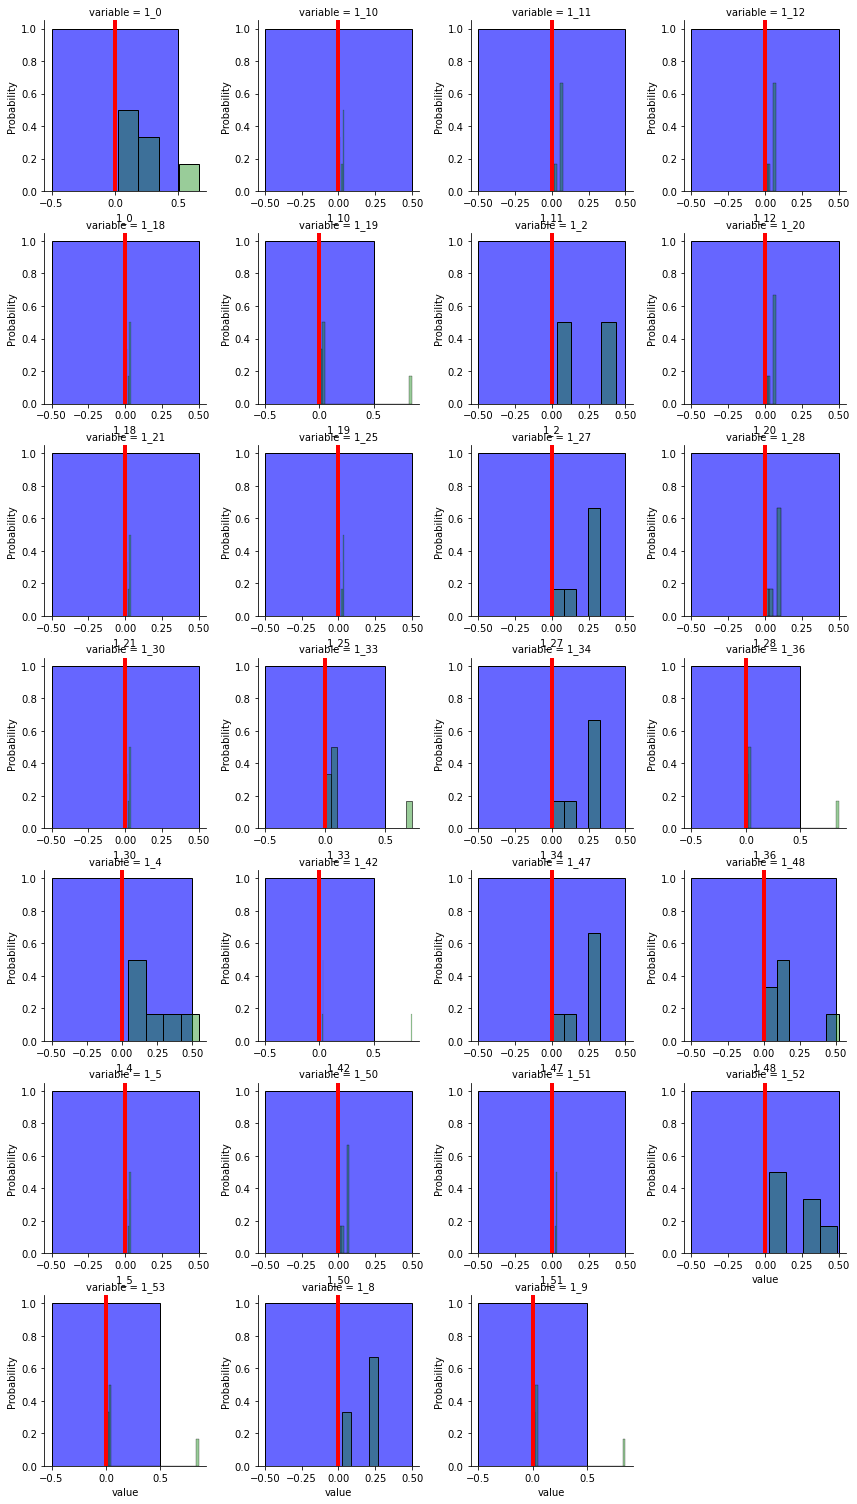

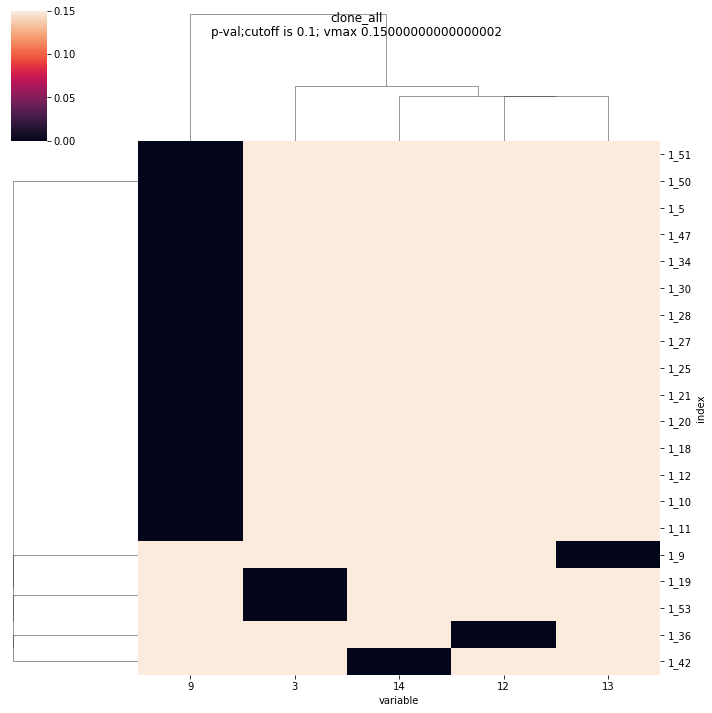

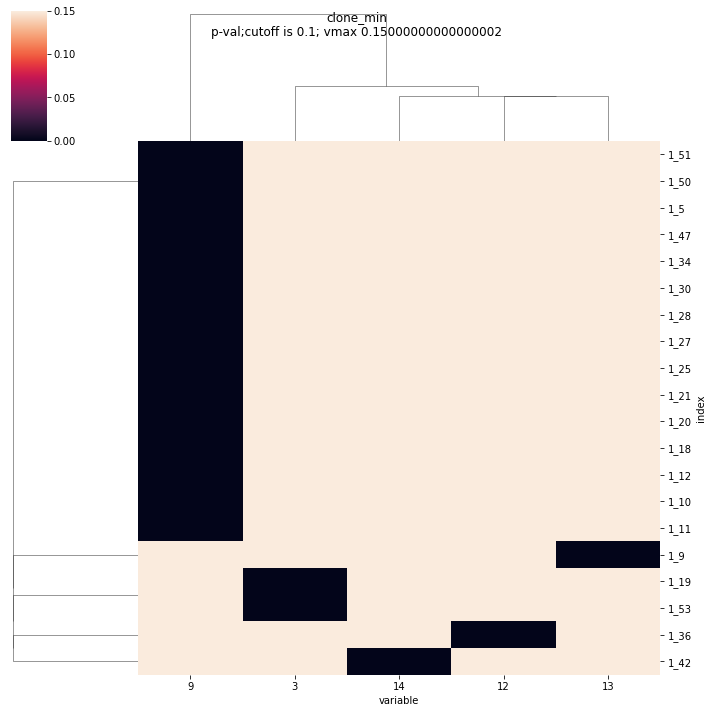

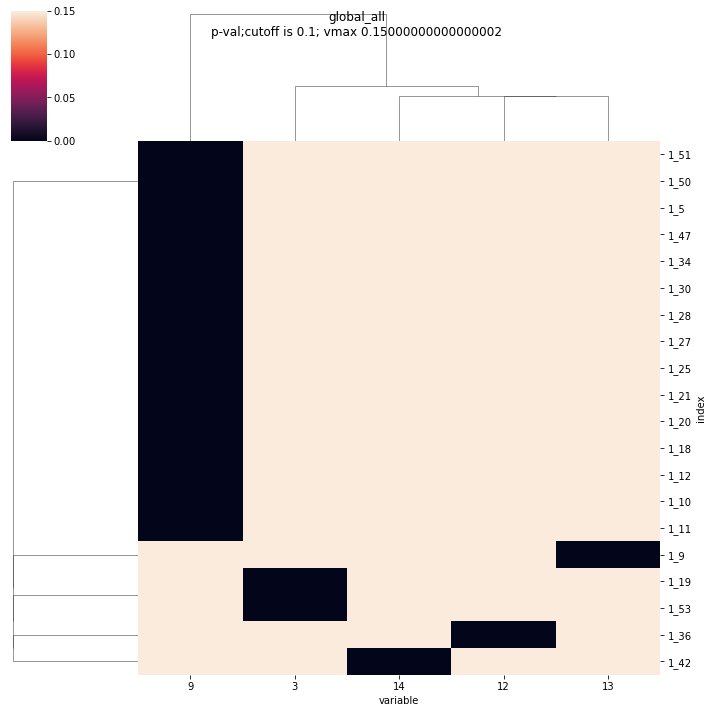

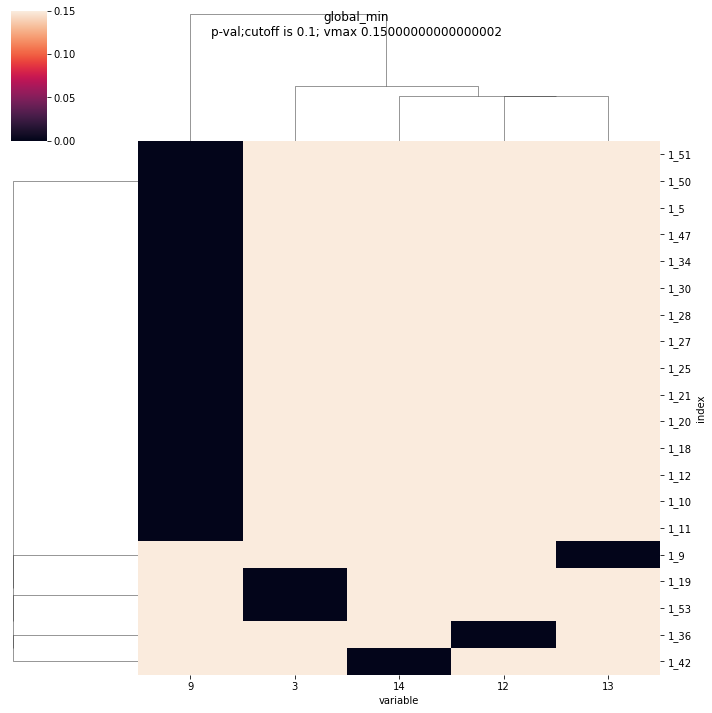

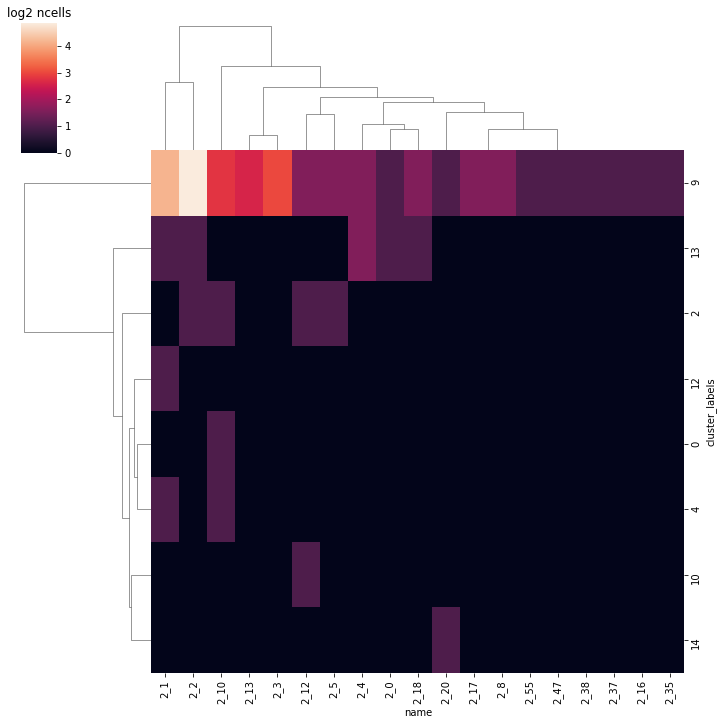

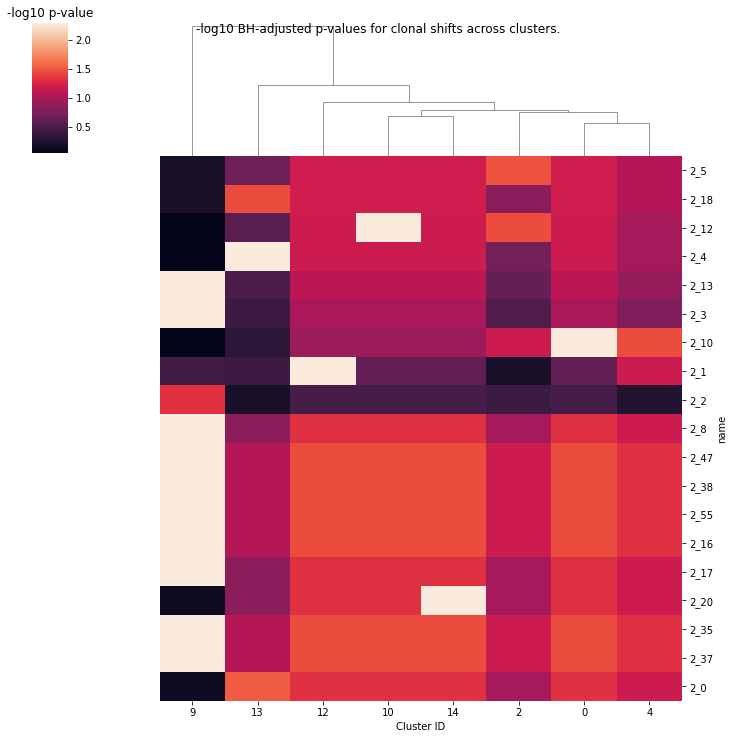

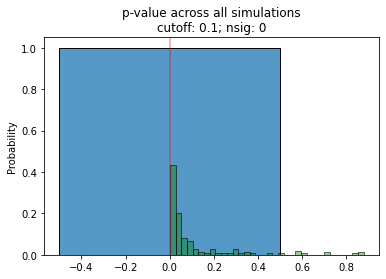

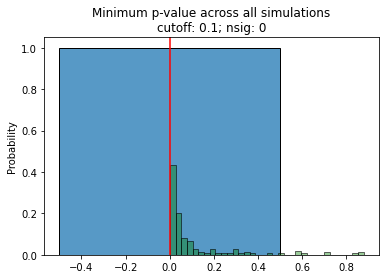

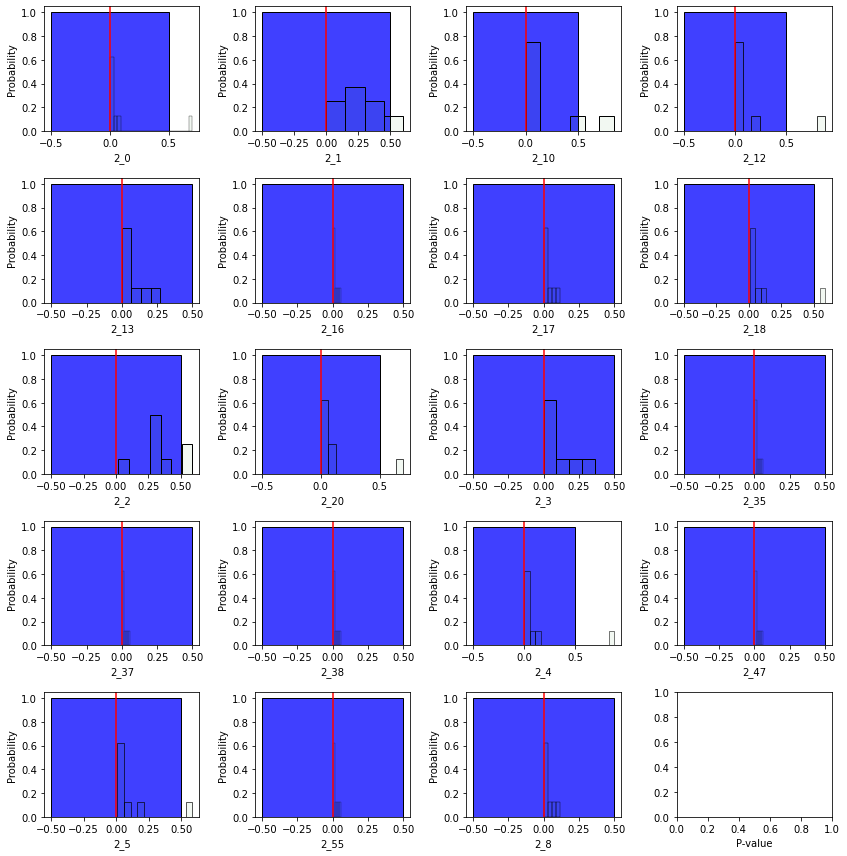

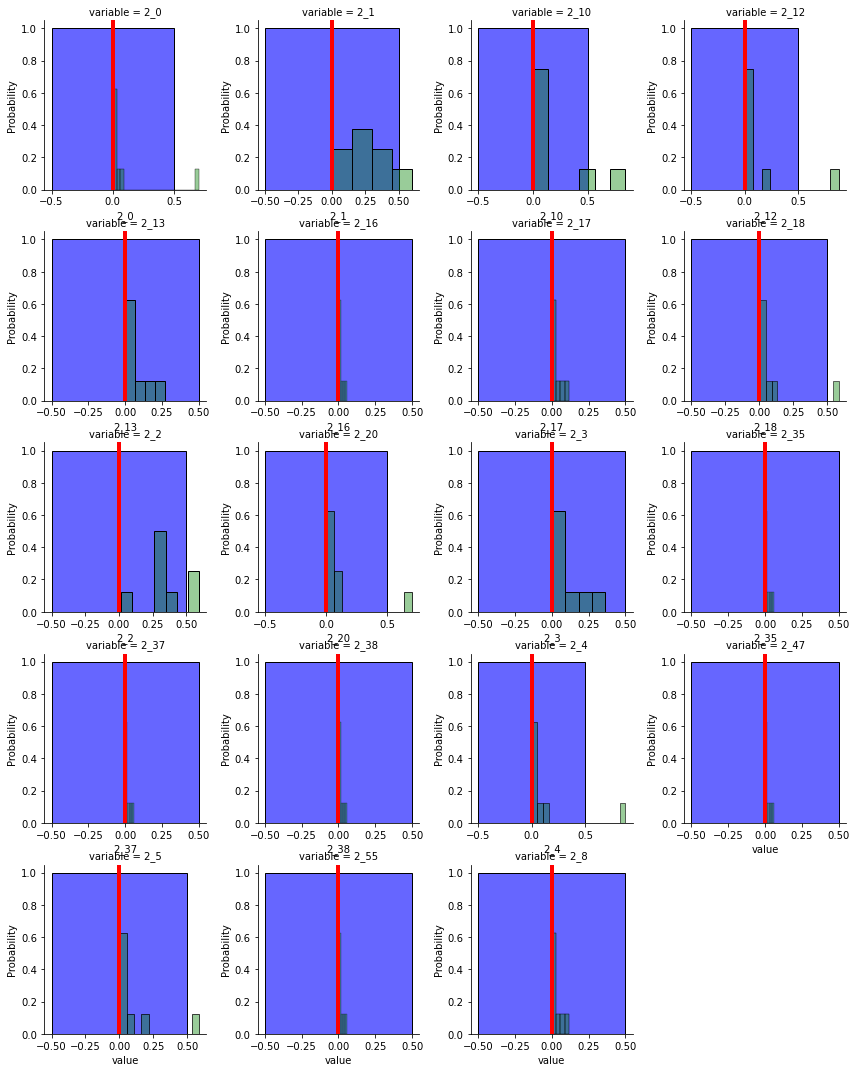

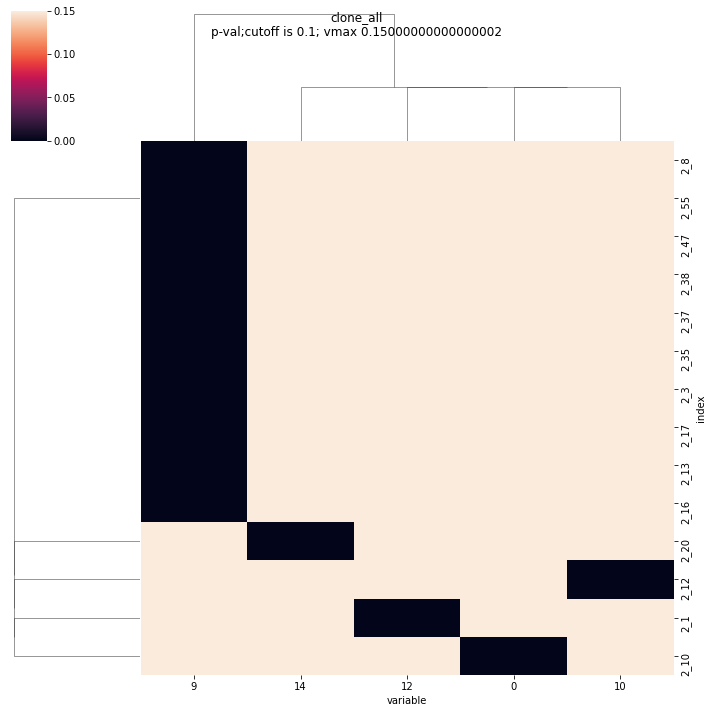

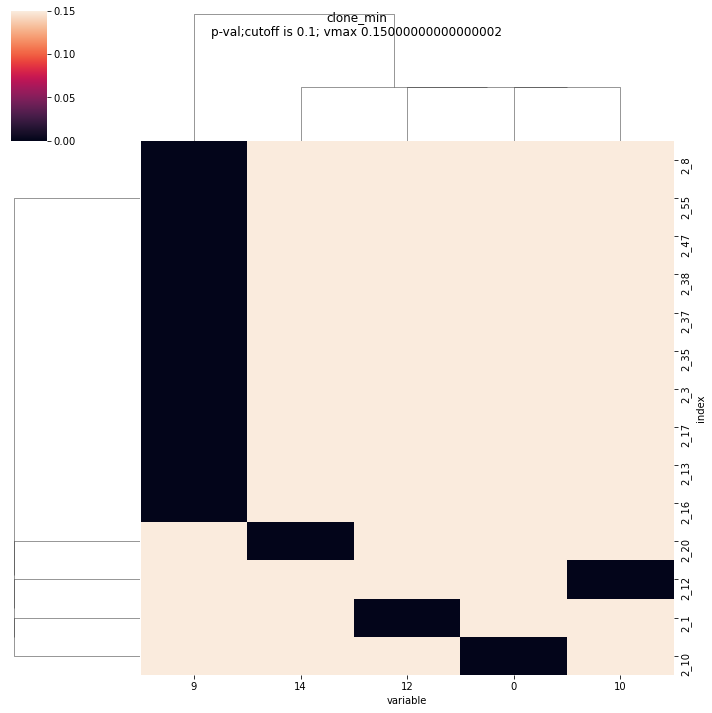

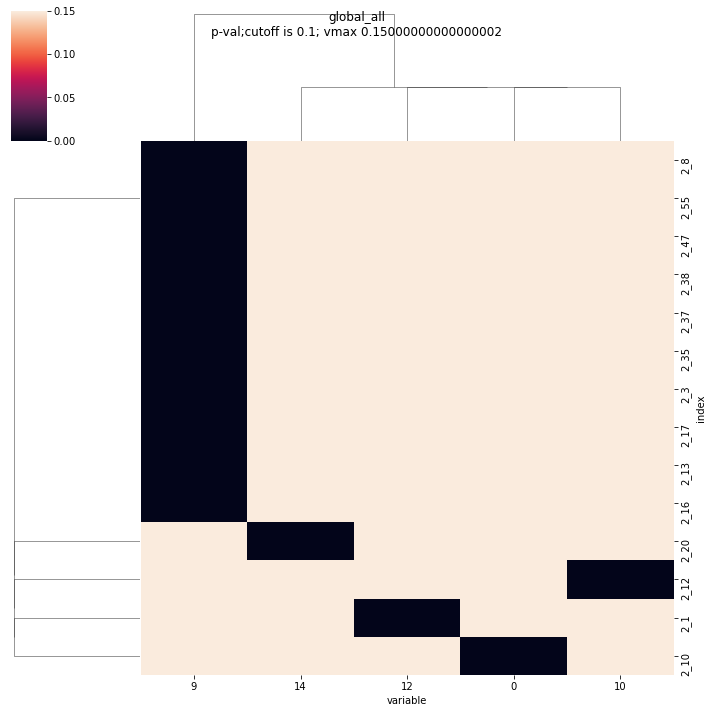

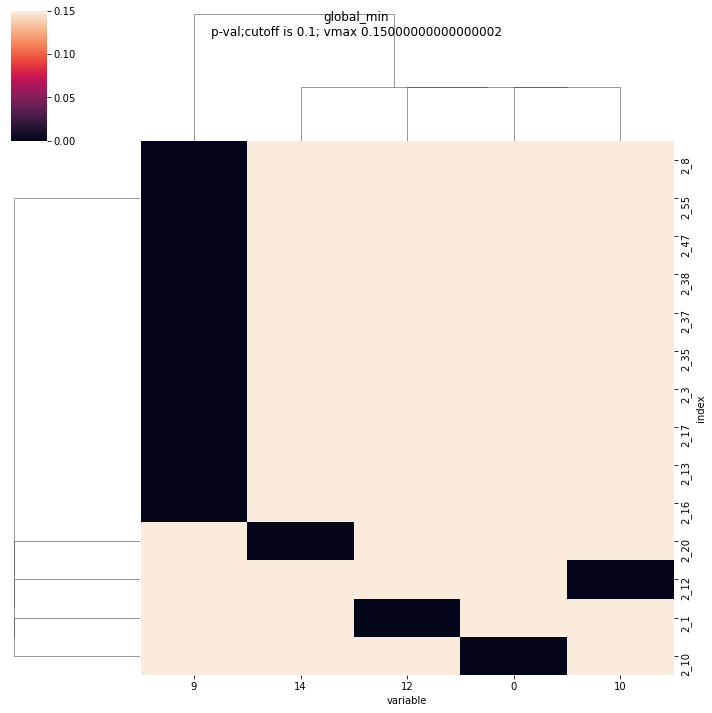

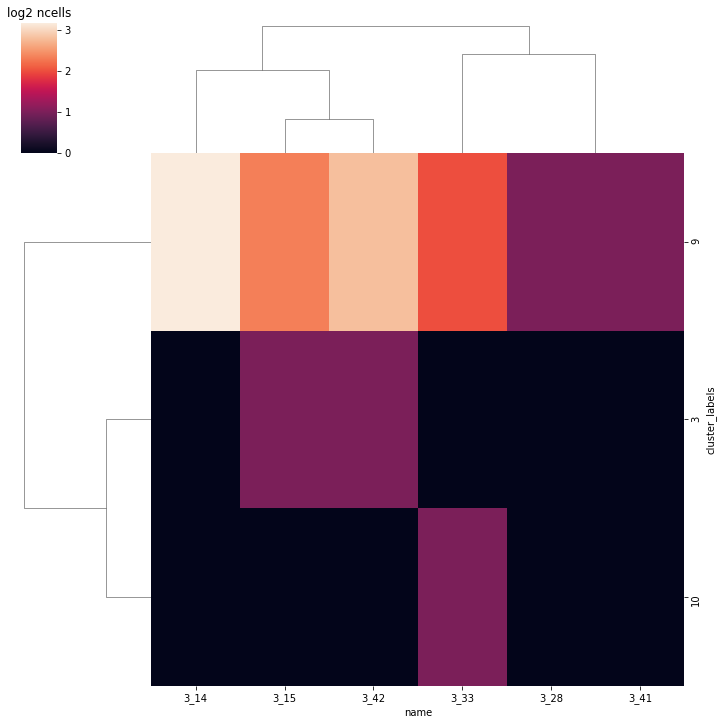

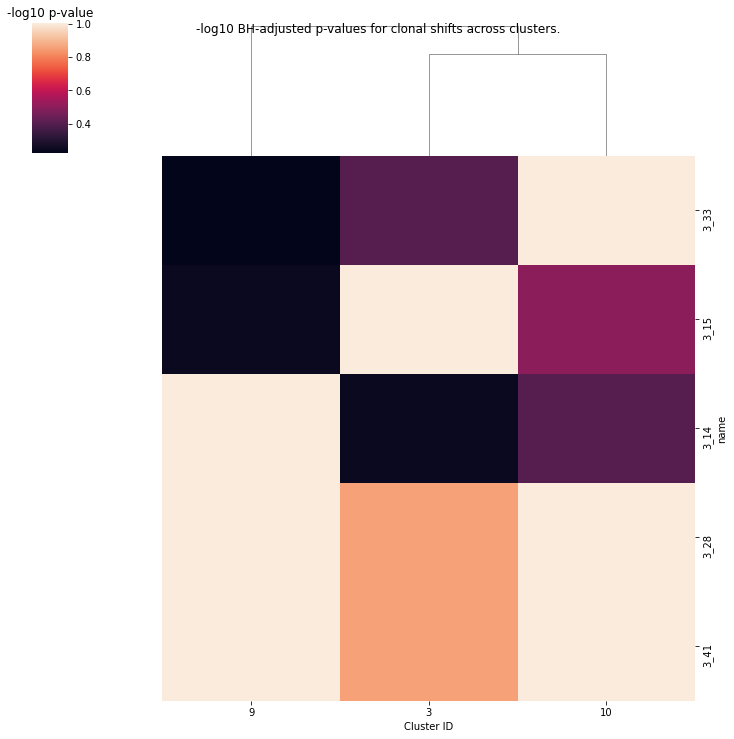

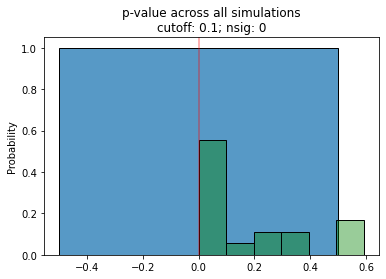

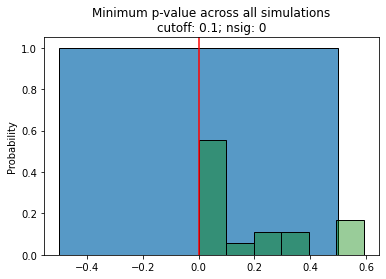

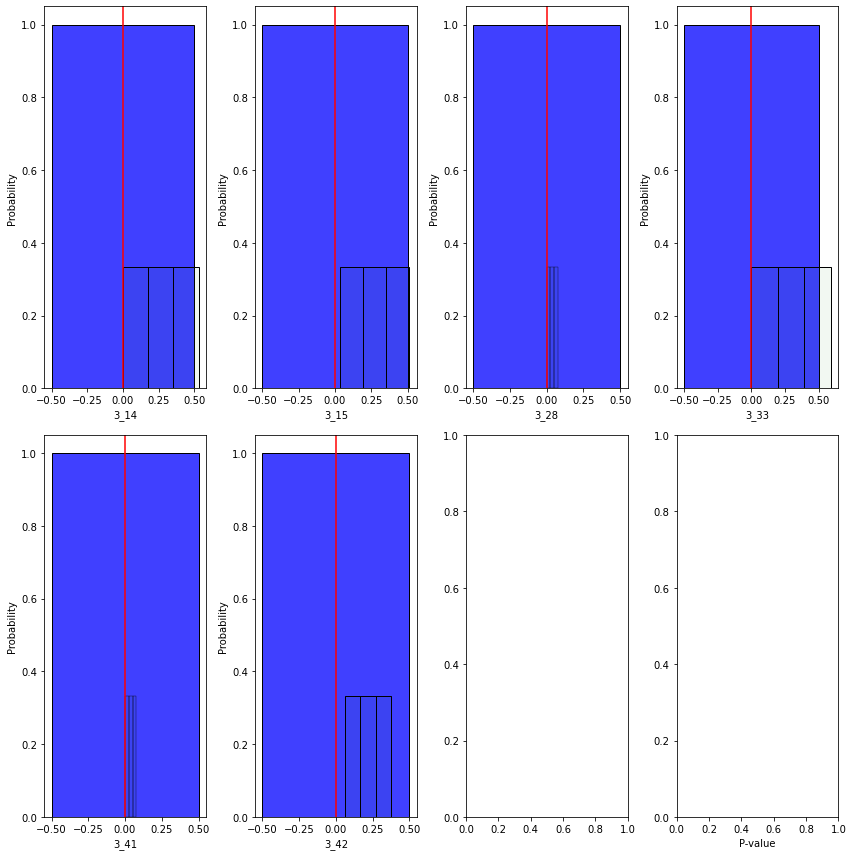

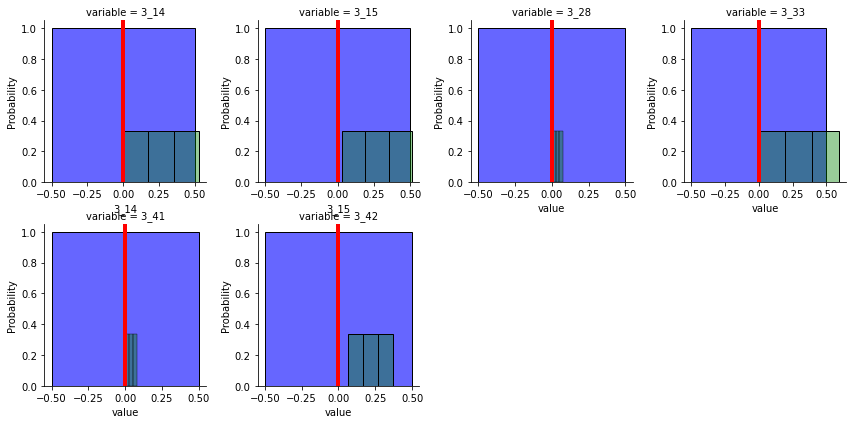

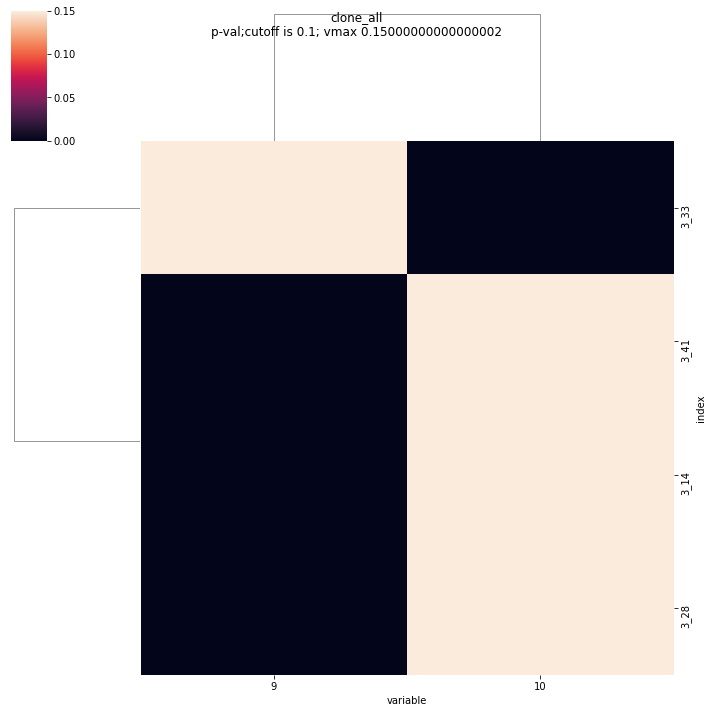

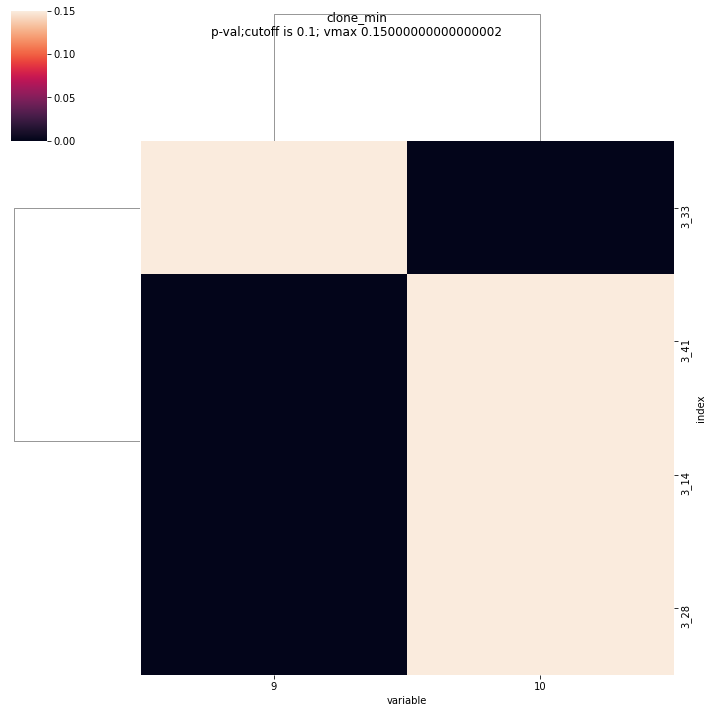

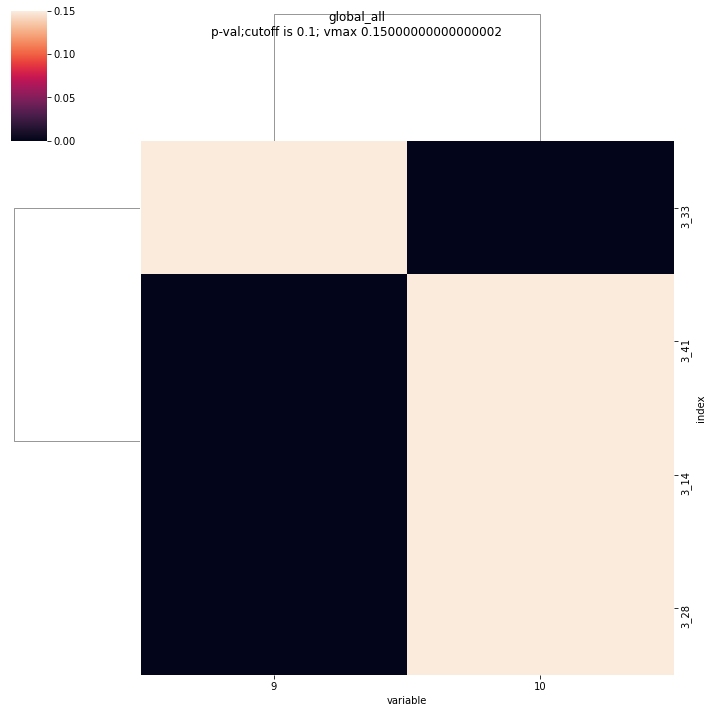

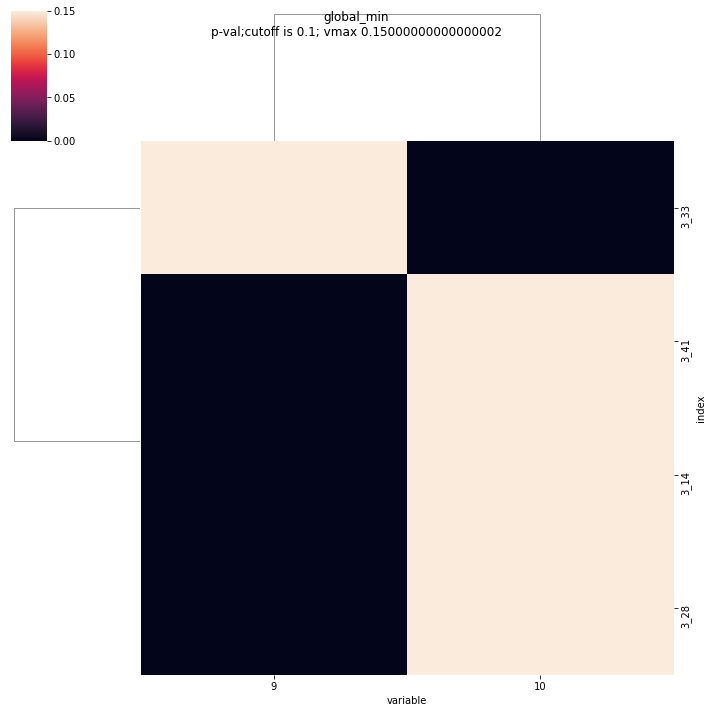

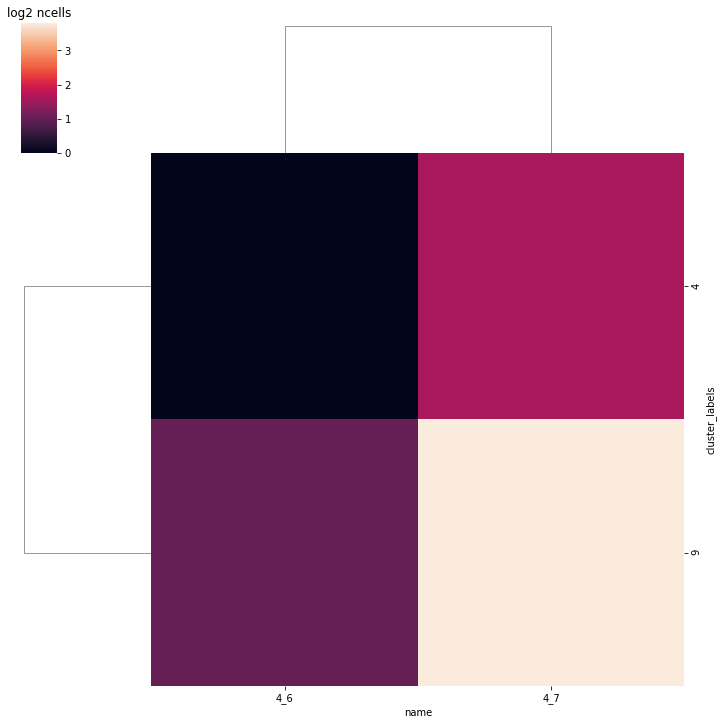

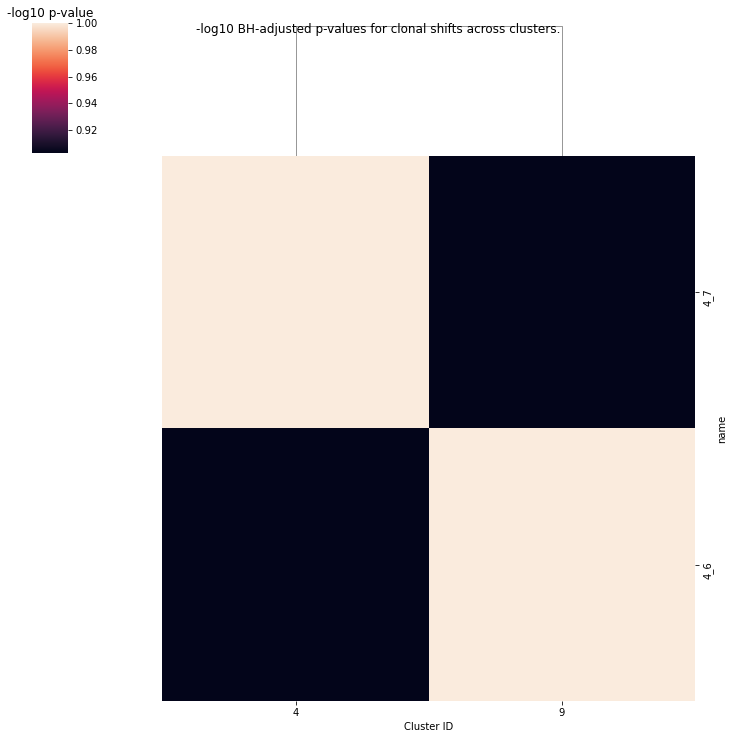

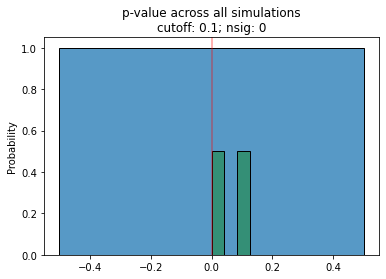

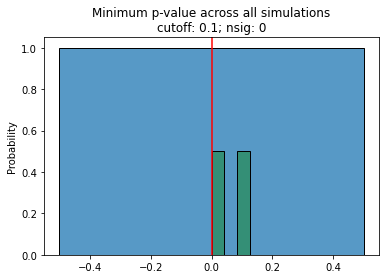

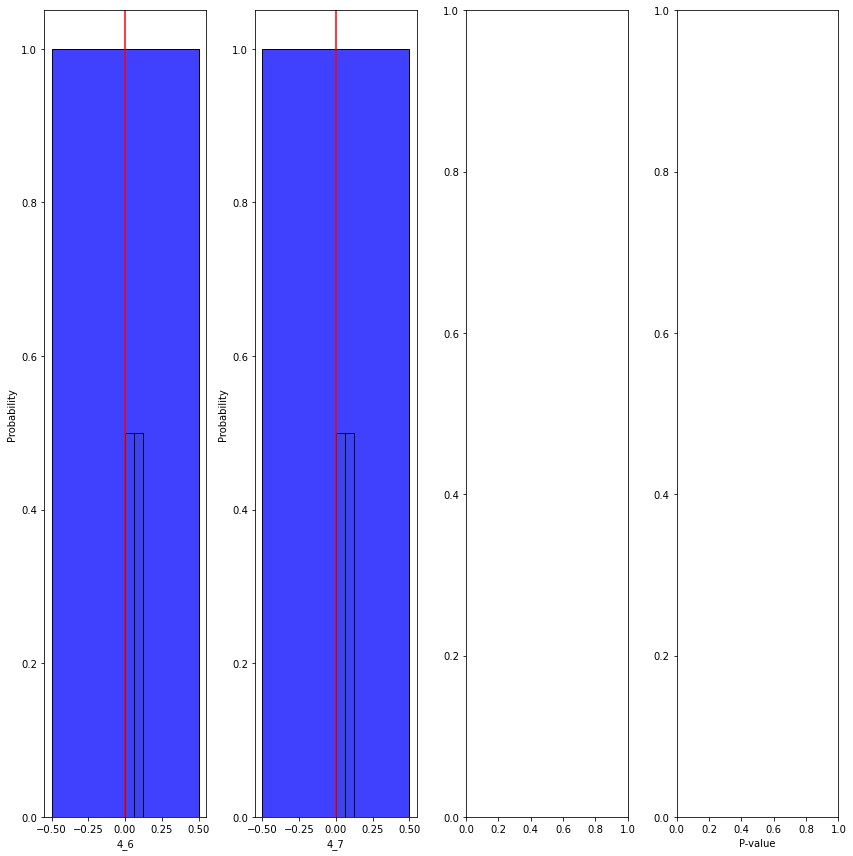

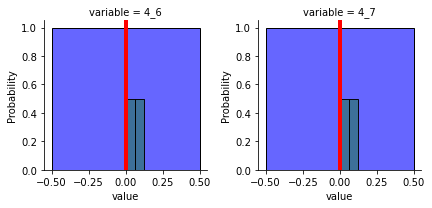

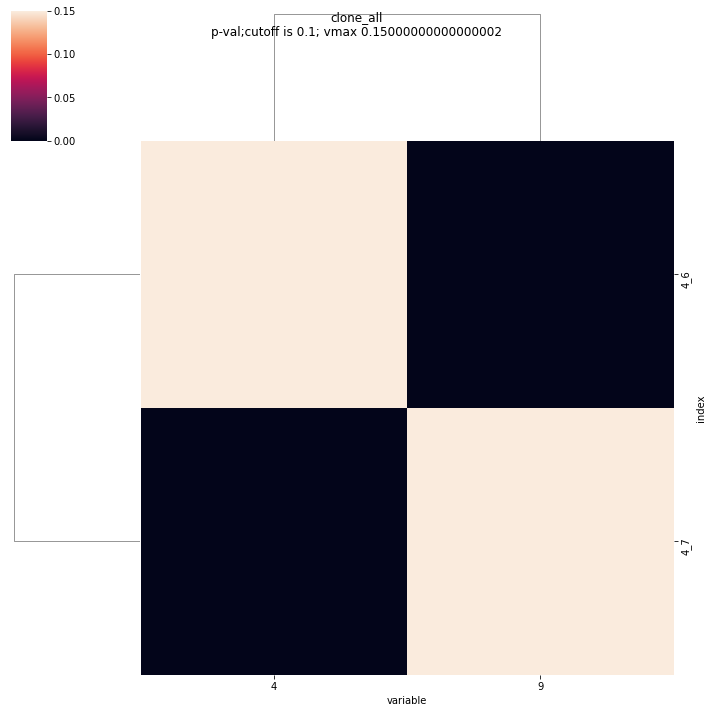

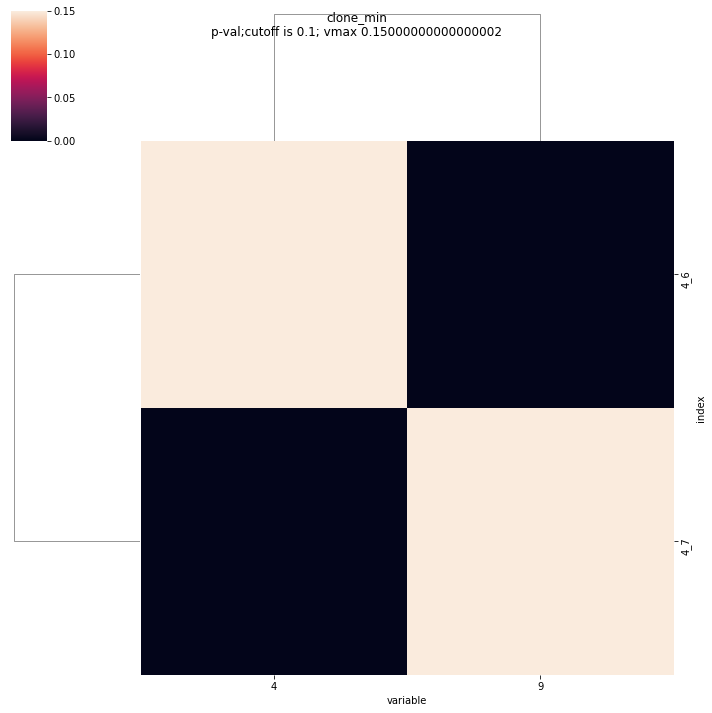

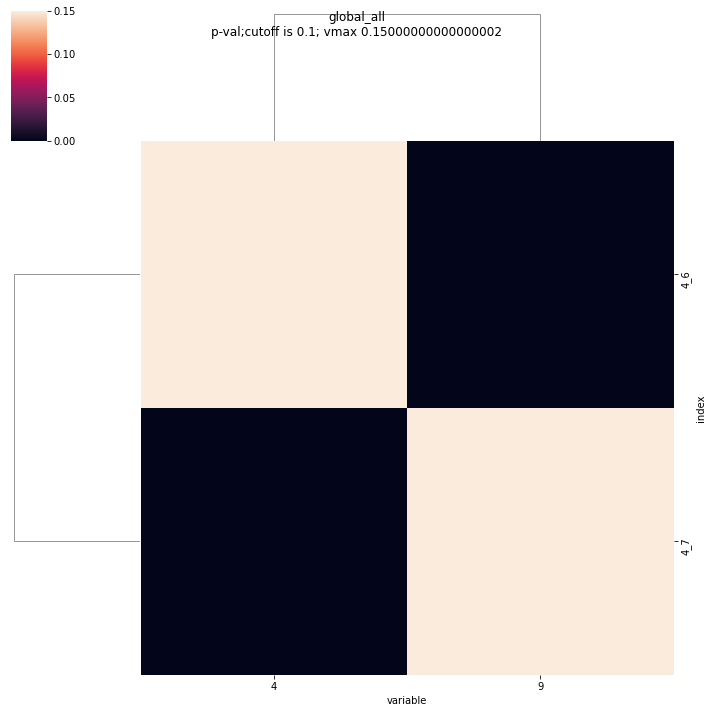

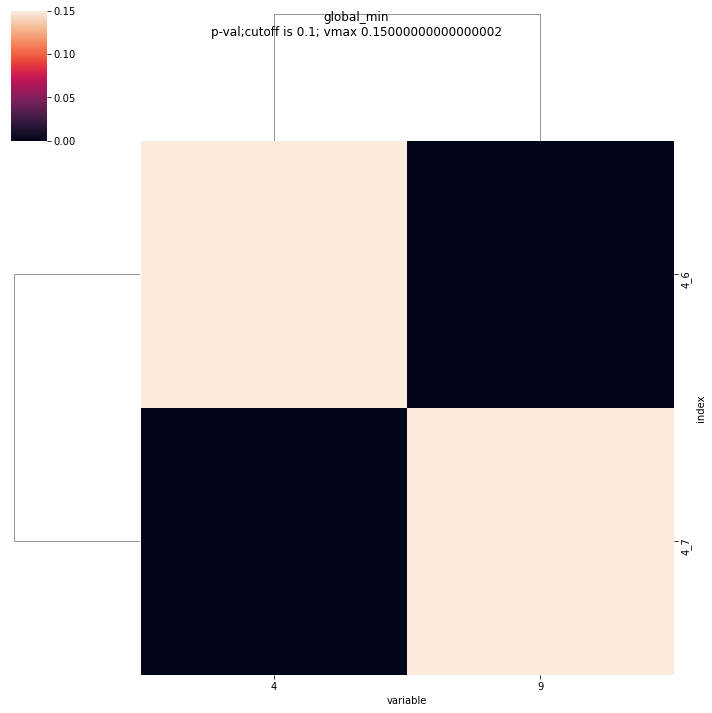

In [7]:
for d, val in cells_meta.groupby("donor"):
    print('donor', d)
    curr_groups = val.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
    curr_groups
    curr_sizes = val.groupby(clone_col).size().sort_values(ascending=False)
    curr_name_cond_size = val.groupby([clone_col]).size()
    curr_name_cond_size = curr_name_cond_size[curr_name_cond_size>min_clone_size]
    curr_clones_filt = curr_name_cond_size.index 
    curr_sizes = curr_sizes.loc[curr_clones_filt].sort_values(ascending=False)
    
    curr_clones = np.unique(curr_groups[clone_col])
    curr_clone_map = {x:ind for ind,x in enumerate(curr_clones)}
    print(curr_clones)
    curr_atac_cl = np.unique(curr_groups[atac_col])
    print(curr_atac_cl)

    curr_don_out = donor_out[int(d)]
    
    # Run init hypergeo and the counts data
    cs.hypergeo_plots(curr_groups, curr_clones, curr_atac_cl, curr_sizes, p_thresh, atac_col,
                   clone_col, curr_don_out)
    
    out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(curr_groups, curr_don_out, atac_col, clone_col, p_thresh, curr_clones, 
                                                      curr_atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                                  n_cpus=n_cpus)

#     print("plotting counts")
#     curr_groups["log2_count"] = np.log2(curr_groups["count"]+1)
#     g = sns.clustermap(curr_groups.pivot(index=atac_col,columns=clone_col, values="log2_count").fillna(0))
#     plt.gca().set_title("log2 ncells")
#     plt.savefig(join(curr_don_out, "ncells.png"))
#     curr_groups = curr_groups.drop("log2_count", axis=1)
    
#     output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes,
#                                                              p_thresh=p_thresh, atac_col=atac_col, 
#                                                               clone_col=clone_col)

    
#     bh_enrichment_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted.csv"))
#     output_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.csv"))
    
#     if output_df.shape[0] == 0:   
#         g = sns.clustermap(-np.log10(bh_enrichment_df.fillna(1)), 
#                        row_cluster=False)
#         g.fig.suptitle("No groups were significant")
#     else:
#         g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                        row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
#     g.fig.suptitle(f"Hypergeometric distribution p-values - non-significant values (p={p_thresh}) are zeroes")
#     plt.savefig(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.png"))
    
#     init_bh_enrichment = cs.create_enrichment(curr_groups, atac_col, clone_col, p_thresh,
#                                               clones=curr_clones, atac_cl=curr_atac_cl)
    
#     shuffle = cs.shuffle_hypergeo(curr_groups, atac_col, clone_col, p_thresh, curr_clones, curr_atac_cl, 
#                                   n_shuffle=n_shuffle, to_parallel=True, n_cpus=n_cpus)

#     results_df, out_d = cs.get_out(shuffle, curr_clones, init_bh_enrichment, p_thresh, 
#                                                           curr_clone_map, atac_col, 
#                                                           outdir=join(curr_don_out, "shuffle"))
    
    


## B) Run using all donors as background

Running hypergeo and saving sig results
plotting counts
Running hypergeo shuffle and saving sig results


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 6
bh shape (24, 9)


ic| 'clone min'


out_df     index variable  value      method
11   2_10        0    0.0  global_all
98   1_27        9    0.0  global_all
99   1_28        9    0.0  global_all
100  1_34        9    0.0  global_all
102  1_47        9    0.0  global_all
109  2_13        9    0.0  global_all
112   2_3        9    0.0  global_all
115  3_14        9    0.0  global_all
11   2_10        0    0.0  global_min
98   1_27        9    0.0  global_min
99   1_28        9    0.0  global_min
100  1_34        9    0.0  global_min
102  1_47        9    0.0  global_min
109  2_13        9    0.0  global_min
112   2_3        9    0.0  global_min
115  3_14        9    0.0  global_min
11   2_10        0    0.0   clone_all
98   1_27        9    0.0   clone_all
99   1_28        9    0.0   clone_all
100  1_34        9    0.0   clone_all
102  1_47        9    0.0   clone_all
109  2_13        9    0.0   clone_all
112   2_3        9    0.0   clone_all
115  3_14        9    0.0   clone_all
11   2_10        0    0.0   clone_min
98   

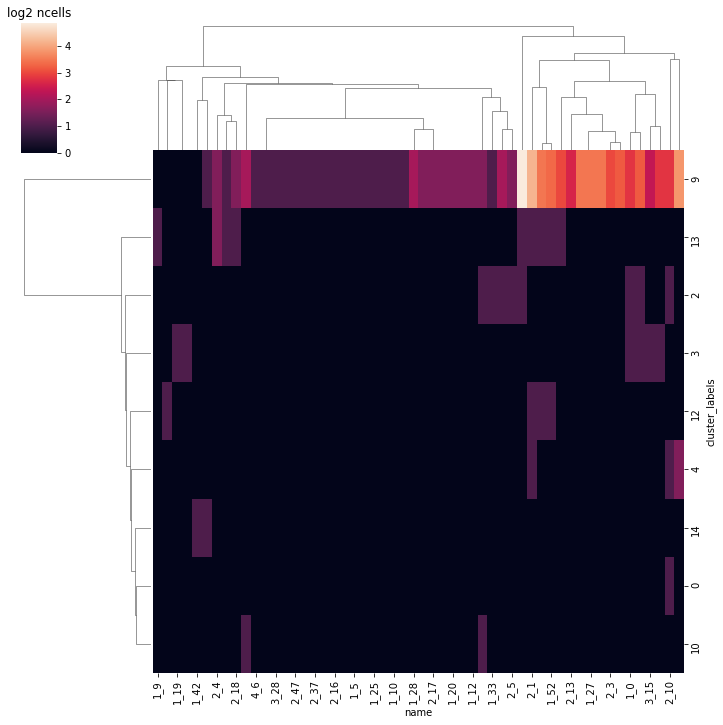

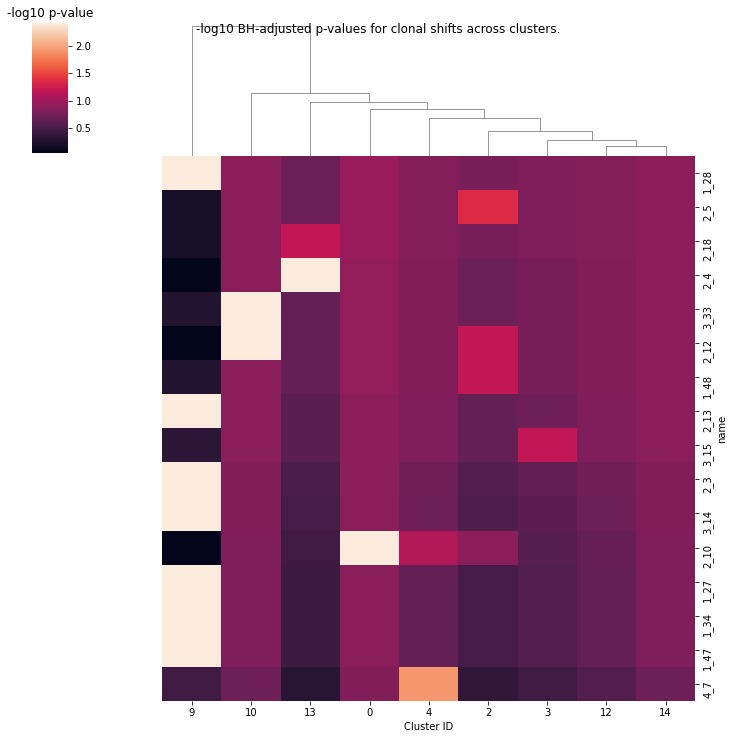

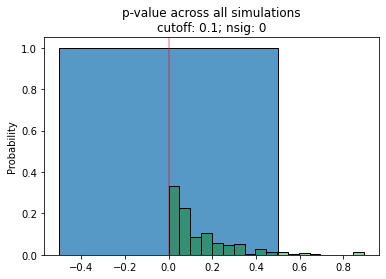

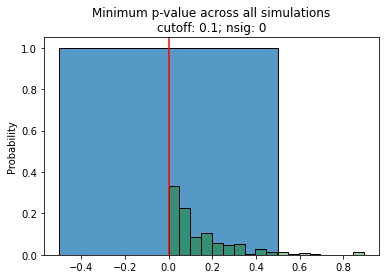

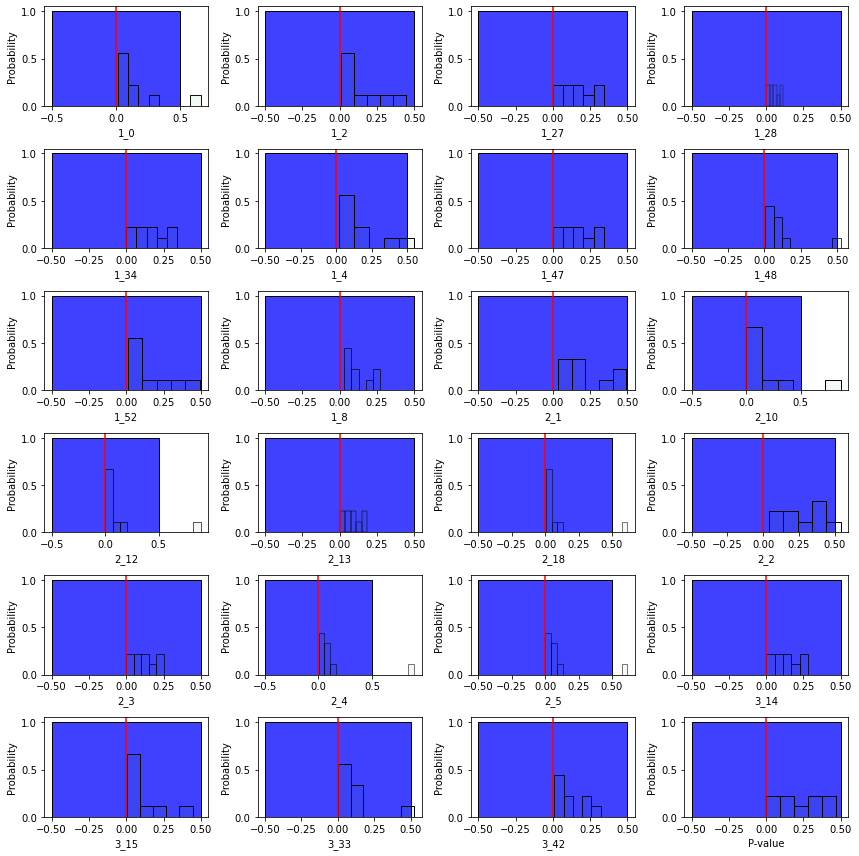

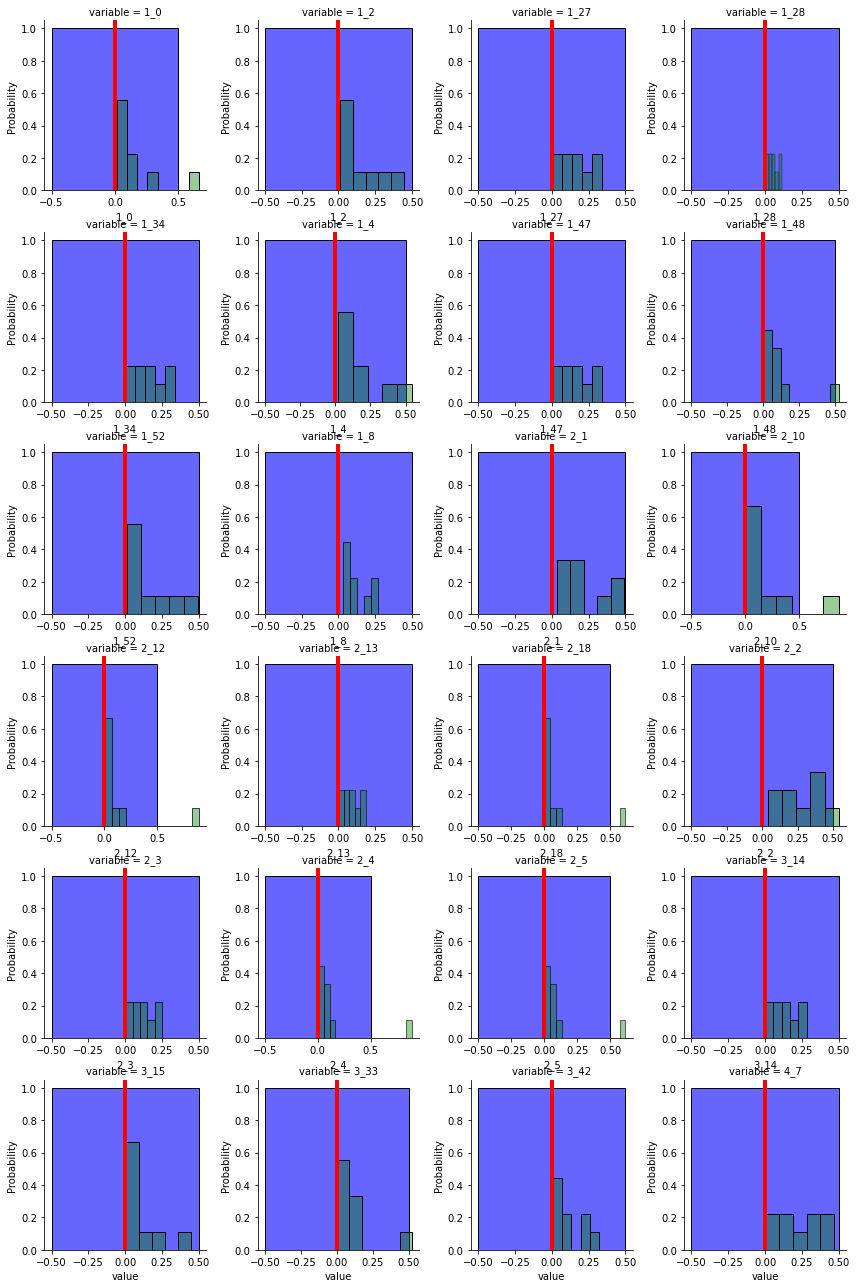

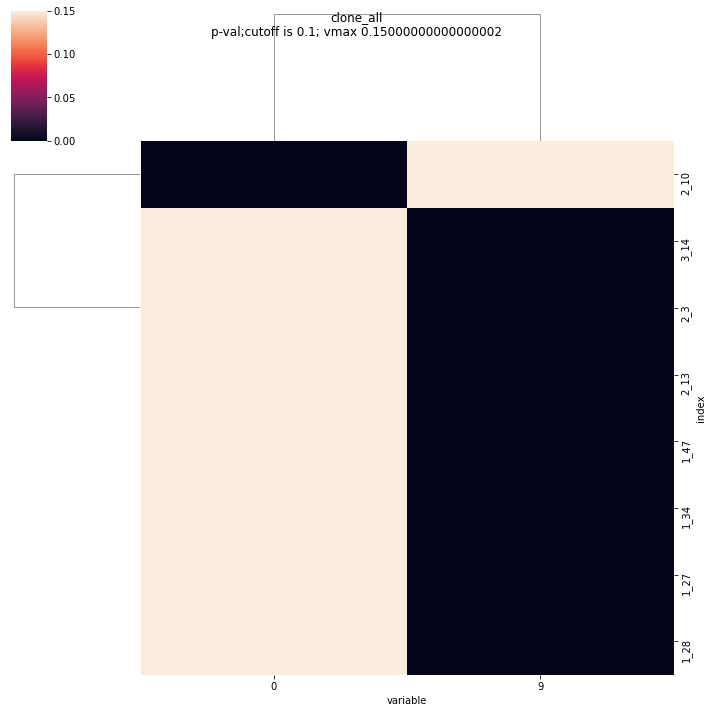

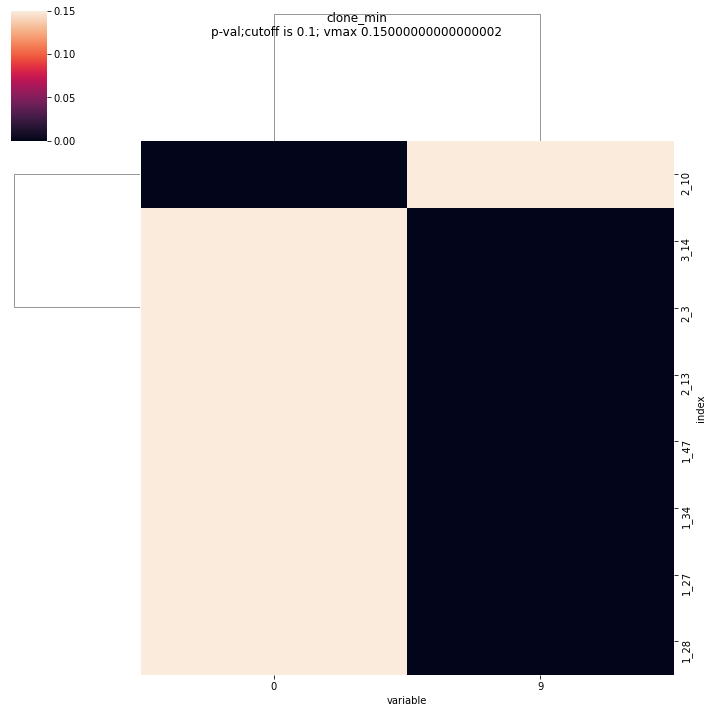

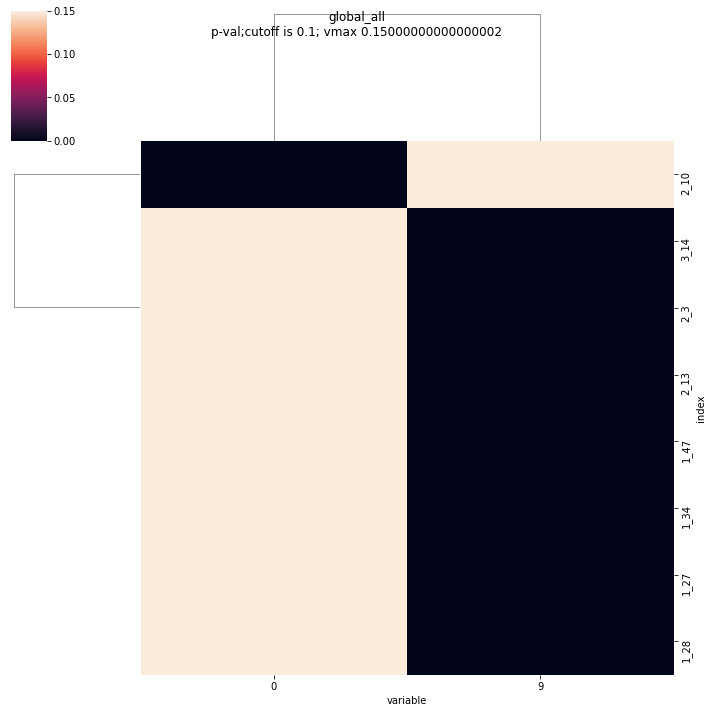

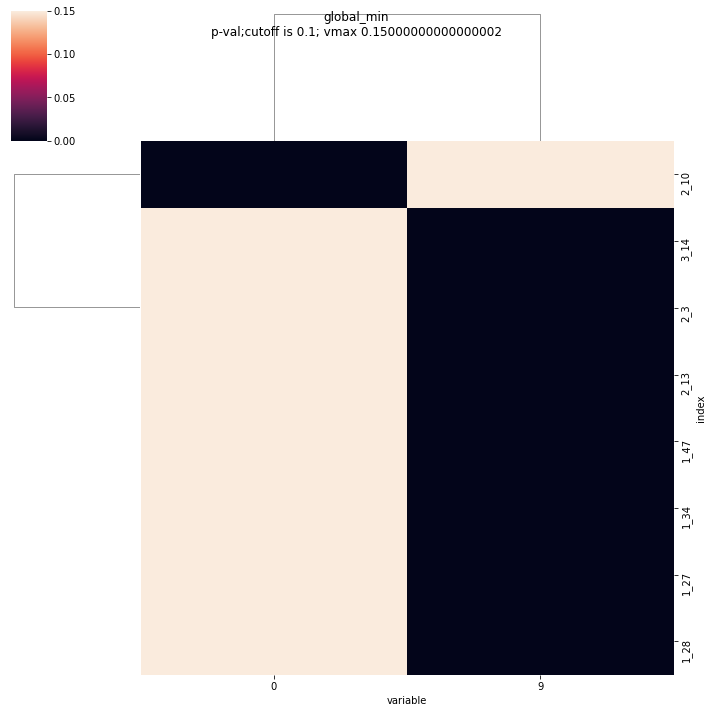

In [8]:
sizes = cells_meta.groupby(clone_col).size().sort_values(ascending=False)
name_cond_size = cells_meta.groupby([clone_col]).size()
name_cond_size = name_cond_size[name_cond_size>min_clone_size]
clones_filt = name_cond_size.index 

sizes = sizes.loc[clones_filt].sort_values(ascending=False)
clones_filt

groups = cells_meta.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
groups

clones = clones_filt.values #np.unique(groups["name"])
clone_map = {x:ind for ind,x in enumerate(clones)}

atac_cl = np.unique(groups[atac_col])
atac_cl


# Run init hypergeo
cs.hypergeo_plots(groups, clones, atac_cl, sizes, p_thresh, atac_col,
               clone_col, all_dir)
## Run shuffle
print("Running hypergeo shuffle and saving sig results")
out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(groups, all_dir, atac_col, clone_col, p_thresh, clones, 
                                                  atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                              n_cpus=n_cpus)

# # plot just the counts
# print("plotting counts")
# groups["log2_count"] = np.log2(groups["count"]+1)
# g = sns.clustermap(groups.pivot(index=atac_col,columns=clone_col, values="log2_count").fillna(0))
# plt.gca().set_title("log2 ncells")
# plt.savefig(join(all_dir, "ncells.png"))


# print("Running hypergeo and saving sig results")
# output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(groups, clones, atac_cl, sizes,p_thresh, atac_col, clone_col)
# bh_enrichment_df.to_csv(join(all_dir, "hypergeo_padjusted.csv"))
# output_df.to_csv(join(all_dir, "hypergeo_padjusted_sigOnly.csv"))
    
# if output_df.shape[0] == 0:   
#     g = sns.heatmap(-np.log10(bh_enrichment_df.fillna(1)))
#     g.fig.suptitle("No groups were significant")
# else:
#     g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                    row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
# plt.savefig(join(all_dir, "hypergeo_padjusted_sigOnly.png"))

# init_bh_enrichment = cs.create_enrichment(groups, atac_col, clone_col, p_thresh,
#                                           clones=clones, atac_cl=atac_cl)

# shuffle = cs.shuffle_hypergeo(groups, atac_col, clone_col, p_thresh, clones, atac_cl, n_shuffle=n_shuffle, 
#                               to_parallel=True, n_cpus=24)

# results_df, out_d = cs.get_out(shuffle, clones, init_bh_enrichment_df, p_thresh, clone_map, atac_col, 
#                                                       all_dir=sim_all_dir)

In [9]:
out_df

,index,variable,value,method
11,2_10,0,0.0,clone_all
98,1_27,9,0.0,clone_all
99,1_28,9,0.0,clone_all
100,1_34,9,0.0,clone_all
102,1_47,9,0.0,clone_all
109,2_13,9,0.0,clone_all
112,2_3,9,0.0,clone_all
115,3_14,9,0.0,clone_all
11,2_10,0,0.0,clone_min
98,1_27,9,0.0,clone_min


In [10]:
# results_df

# ## Plot shuffle p-value heatmap for each method 

# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     sns.clustermap(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1),
#                   vmax=p_thresh+0.1)
#     plt.suptitle(ind)

# ## Same but log10

# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     min_m = min(val.loc[val["value"] != 0 , "value"])
#     val.loc[val["value"] == 0 ,"value"] = min_m
    
#     g = sns.clustermap(-np.log10(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1)))
#     plt.suptitle(ind)
#     g.ax_cbar.set(title=f"-log10 p-val;cutoff is {-np.log10(p_thresh)}")
#     # g.ax_cbar.set(title="-log10 p-value")

    
    

# ## Save significant results_df

# out_df = results_df.rename({"value":"p_value shuffle", "index":"clone", "variable":"lineage"}, axis=1)
# out_df = out_df[out_df["p_value shuffle"]<p_thresh]

# init_p_df = init_bh_enrichment.reset_index().melt(id_vars=["index"]).rename({"variable":"lineage", "index":"clone",
#                                                                           "value": "BH_p_adj"},axis=1).set_index(["clone", "lineage"])
# init_p_df
# #pd.merge(init_p_df, out_df, on=["clone", "lineage"], how="inner" )

# out_df["BH_p_adj"] = out_df.apply(lambda x:init_p_df.loc[(x["clone"],x["lineage"]), "BH_p_adj"], axis=1)
# out_df

# out_df.sort_values(["method", "p_value shuffle", "BH_p_adj"])

# out_df[out_df["BH_p_adj"] != 1]